In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import imghdr 
import warnings
import os
import matplotlib.pyplot as plt 
import numpy as np
warnings.filterwarnings('ignore')

C:\Users\hp\AppData\Local\Temp\ipykernel_24228\2811411102.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [3]:
animes_dir = './data/'

In [4]:
for image_class in os.listdir(animes_dir):
    for image in os.listdir(os.path.join(animes_dir, image_class)):
        image_path = os.path.join(animes_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e :
            print('Issue with image {}'.format(image_path))

In [5]:
data = keras.preprocessing.image_dataset_from_directory("data/")

Found 314 files belonging to 3 classes.


In [6]:
data_iter = data.as_numpy_iterator()

In [7]:
batch = data_iter.next()

In [8]:
batch[0].shape

(32, 256, 256, 3)

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [10]:
# 0 : happy 
# 1 : neutral
# 2 : sad

In [11]:
data = data.map(lambda x, y: (x/255, y))

In [12]:
scaled_iter = data.as_numpy_iterator()
batch = scaled_iter.next()

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [14]:
len(data)

10

In [15]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2) 
test_size = int(len(data)*0.1) 

train_size, val_size, test_size

(7, 2, 1)

In [48]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)
# Number of classes (positive, negative, neutral)
num_classes = 3

# One-hot encoding function
def one_hot_encode(label):
    return tf.one_hot(label, depth=num_classes)

# Apply one-hot encoding to the dataset tensors
train = train.map(lambda x, y: (x, one_hot_encode(y)))
val = val.map(lambda x, y: (x, one_hot_encode(y)))
test = test.map(lambda x, y: (x, one_hot_encode(y)))


In [19]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape=(256, 256, 3))
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(13, activation='softmax'))

In [49]:
def myModel():
    model = keras.Sequential([
        
        keras.layers.Conv2D(20, (3, 3), activation=tf.nn.relu, input_shape=(256, 256, 3)),
        keras.layers.MaxPooling2D(),
        
        
        keras.layers.Conv2D(20, (3, 3), activation=tf.nn.relu),
        keras.layers.MaxPooling2D(),
        
        
        keras.layers.Flatten(),
        keras.layers.Dense(61, activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',  metrics=['accuracy'])
    return model

In [50]:
# model.compile(optimizer='adam',loss='categorical_crossentropy',  metrics=['accuracy'])
model = myModel()

In [51]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 20)   │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 76880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 61)             │     4,689,741 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           186 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,694,107 (17.91 MB)

 Trainable params: 4,694,107 (17.91 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - accuracy: 0.3790 - loss: 5.9246 - val_accuracy: 0.3906 - val_loss: 2.9512
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 493ms/step - accuracy: 0.5434 - loss: 1.9977 - val_accuracy: 0.7031 - val_loss: 1.1492
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - accuracy: 0.5565 - loss: 1.0975 - val_accuracy: 0.6875 - val_loss: 0.7462
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - accuracy: 0.7445 - loss: 0.7063 - val_accuracy: 0.8281 - val_loss: 0.6861
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - accuracy: 0.8521 - loss: 0.6565 - val_accuracy: 0.8594 - val_loss: 0.5319
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step - accuracy: 0.8286 - loss: 0.5090 - val_accuracy: 0.9219 - val_loss: 0.3492
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 563ms/step - accuracy: 0.8566 - loss: 0.3860 - val_accuracy: 0.9375 - val_loss: 0.1992
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.9414 - loss: 0.2252 - val_accuracy: 0.9375 - val_loss: 0.1941
Epo

In [28]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

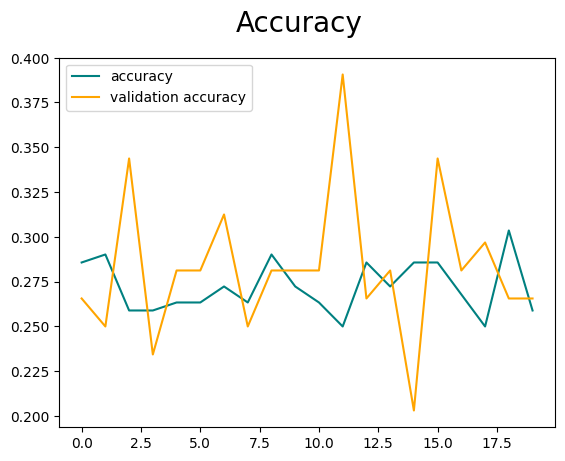

In [29]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='validation accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

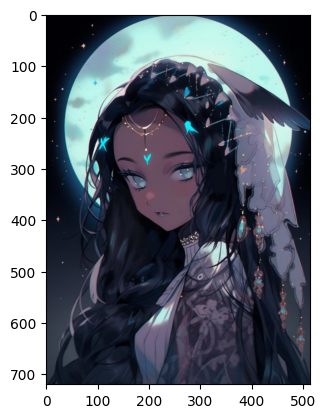

In [62]:
img = cv2.imread("C:\\Users\\hp\\Downloads\\girl.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

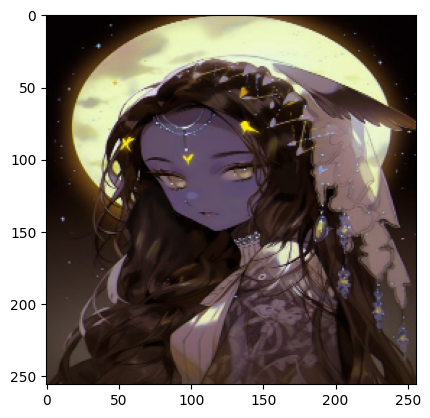

In [63]:
resized = tf.image.resize(img, (256, 256))
plt.imshow(resized.numpy().astype(int))

In [64]:
yhat = model.predict(np.expand_dims(resized/255, 0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [65]:
yhat

array([[8.4005374e-01, 1.9996466e-04, 1.5974630e-01]], dtype=float32)